<a href="https://colab.research.google.com/github/JaeminKIM-Irene/FC_AI_Track_Learning/blob/main/CV/tutorial/%5BCV_realtime%5D4.%20Cat_and_Dog_classification_project_with_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification

모델이 데이터를 효율적으로 학습할 수 있도록 구현해보는게 목적입니다.

* Data augmentation을 이용해 오버피팅을 방지해봅시다.

기본적인 머신러닝 작업과정은 아래와 같습니다.

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

* 모델 완성 후 평가 지표에 따라서 모델을 평가해 봅시다.

## Project 설명
### Task
* 적은 수의 강아지와 고양이 사진을 이용해 classification을 진행해보자.
* 주어진 데이터를 Augmentation 하는 법과 딥러닝 트레이닝 과정을 구현해 보는것이 목표입니다.
* 데이터셋은 학습 데이터엔 강아지, 고양이 이미지 1000장이 있고, 테스트용 데이터에는 각각 500장씩 주어져있습니다.
    * 트레이닝 시 image size 조절해 사용

### Baseline
* 기본적으로 사용하는 Convolution layers를 구성해 사용해보자.
* 오버피팅을 방지하기 위한 다양한 방법들을 사용해보자.
    * Data Augmentation, Dropout, Batch Normalization
* Training
* Evaluation
    * 모델의 정확도와 크기를 이용해 점수를 제공하는 메트릭으로 평가해보자.

### Import packages

* 우리가 사용할 packages 를 import 하는 부분 입니다.
* 필요에 따른 packages를 선언합니다.
* 모델 저장을 위해서 구글 드라이브를 마운트해줍니다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms

import os
import requests
import zipfile
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
use_colab = True
assert use_colab in [True, False]

### 데이터셋 다운로드

* 해당 데이터는 개와 고양이 데이터로 구성되어 있습니다.

In [ ]:
def download_and_extract(url, dest_path):
    # 파일 이름 추출
    filename = url.split('/')[-1]
    file_path = os.path.join(dest_path, filename)

    # 파일이 이미 존재하지 않는 경우 다운로드
    if not os.path.exists(file_path):
        response = requests.get(url)
        with open(file_path, 'wb') as file:
            file.write(response.content)

    # 파일이 zip 파일인 경우 압축 해제
    if file_path.endswith('.zip'):
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(dest_path)

# 사용 예시
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
download_and_extract(_URL, './')

### cats_and_dogs_filtered
* |__ train
    * |______ cats: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    * |______ dogs: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
* |__ validation
    * |______ cats: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    * |______ dogs: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]

# 데이터셋 설정
* 다운로드 받은 데이터셋에 대한 경로를 이용하여, 데이터를 이용할 준비를 진행합니다.

In [ ]:
PATH = '/content/cats_and_dogs_filtered'
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [ ]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

* 데이터셋의 구성을 살펴봅시다.

In [ ]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


* 학습 데이터는 고양이와 강아지 이미지 각각 1000 장씩으로 구성되어있습니다.
* 모델 평가를 위해서 각각 500장씩을 validation dataset으로 사용합니다.

### Data preparation 데이터 준비


In [ ]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}

data_dir = '/content/cats_and_dogs_filtered'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
dataset_sizes

{'train': 2000, 'validation': 1000}

### 이미지 샘플 확인

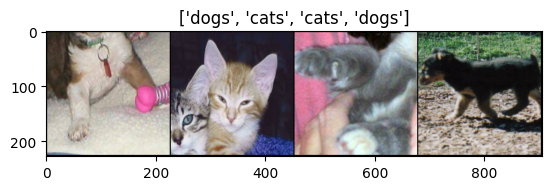

In [ ]:
def imshow(inp, title=None):
    """tensor를 입력받아 일반적인 이미지로 보여줍니다."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
inputs[0].shape

torch.Size([3, 224, 224])

# 모델 구현

* 직접 구현을 진행하거나 Transfer Learning을 진행할 수 있습니다.


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Residual Block 정의
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = F.relu(out)
        return out

# 간단한 ResNet 네트워크 정의
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], 2)
        self.layer3 = self.make_layer(block, 256, layers[2], 2)
        self.layer4 = self.make_layer(block, 512, layers[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# 예시로 ResNet-18 생성
def resnet18():
    return ResNet(ResidualBlock, [2, 2, 3, 3])

# 네트워크 인스턴스화
model = resnet18().to(device)
print(model)


ResNet(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
            Conv2d-3         [-1, 64, 112, 112]          36,864
       BatchNorm2d-4         [-1, 64, 112, 112]             128
            Conv2d-5         [-1, 64, 112, 112]          36,864
       BatchNorm2d-6         [-1, 64, 112, 112]             128
     ResidualBlock-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,864
       BatchNorm2d-9         [-1, 64, 112, 112]             128
           Conv2d-10         [-1, 64, 112, 112]          36,864
      BatchNorm2d-11         [-1, 64, 112, 112]             128
    ResidualBlock-12         [-1, 64, 112, 112]               0
           Conv2d-13          [-1, 128, 56, 56]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# 모델 학습 진행
* 학습을 진행할때, train과 valid 데이터셋을 이용하여 학습과 검증을 동시에 진행합니다.
* 각 데이터셋은 위에서 구성했기 때문에, 모델에서 사용할 데이터의 step의 길이를 batch_size를 이용해 계산해줍니다.

In [ ]:
for epoch in range(10) :
    running_loss = 0.0
    for i, data in enumerate(dataloaders['train']) :
        inputs, labels = data

        optimizer.zero_grad()

        predictions = model(inputs.to(device))
        loss = criterion(predictions, labels.unsqueeze(-1).to(device).float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99 :
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0
print('Finished Training')

In [ ]:
path = './cat_dog.pth'
torch.save(model.state_dict(), path)

# 시험용 데이터로 신경망 검사하기

In [ ]:
model = resnet18()
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
correct = 0
total = 0
threshold = 0.5  # 분류 임계값

# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in dataloaders['validation']:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = model(images.to(device))
        # 출력이 임계값(0.5) 이상이면 1, 아니면 0으로 분류합니다
        predicted = (outputs.data > threshold).float().squeeze()
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct // total} %')

Accuracy of the network on validation images : 50 %
